# Amazon Sales

## Load Libraries

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.streaming import *

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

import os
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Creating a Spark Session
spark = SparkSession.builder \
    .appName("AmazonSalesAnalysis") \
    .getOrCreate()

# Reading the CSV file
# inferSchema: Automatically predicts column types
# header: Indicates that the first line is a heading
df = spark.read.csv("/content/drive/MyDrive/Colab Data/Amazon Sale Report.csv", header=True, inferSchema=True)

# Let's see the first five lines
df.show(5)

+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+--------------------+-----+------------+-----------+
|index|           Order ID|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|  Style|            SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount|  ship-city| ship-state|ship-postal-code|ship-country|       promotion-ids|  B2B|fulfilled-by|Unnamed: 22|
+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+--------------------+-----+------------+-----------+
|    0|405-8078784-5731545|04-30-22|           Cancelled|  Merchant|     Amazon.in|          Standard| SET

## Data Cleaning & Preprocessing

In [4]:
# Handling Missing Values
# 1. Drop rows where 'Amount' or 'Order ID' is null as they are critical for analysis
df = df.dropna(subset=["Amount", "Order ID"])

# 2. Fill missing values in 'currency' with 'INR' (assuming default)
df = df.fillna({"currency": "INR"})

# 3. Fill missing 'Courier Status' with 'Unknown'
df = df.fillna({"Courier Status": "Unknown"})

print("Data Cleaning Completed. Rows with null critical values dropped.")
df.show(5)

Data Cleaning Completed. Rows with null critical values dropped.
+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+--------------------+-----+------------+-----------+
|index|           Order ID|    Date|              Status|Fulfilment|Sales Channel |ship-service-level|  Style|            SKU|     Category|Size|      ASIN|Courier Status|Qty|currency|Amount|  ship-city| ship-state|ship-postal-code|ship-country|       promotion-ids|  B2B|fulfilled-by|Unnamed: 22|
+-----+-------------------+--------+--------------------+----------+--------------+------------------+-------+---------------+-------------+----+----------+--------------+---+--------+------+-----------+-----------+----------------+------------+--------------------+-----+------------+-----------+
|    0|405-8078784-5731545|04-30-22|     

## Feature Engineering

In [5]:
from pyspark.sql.functions import to_date, month, date_format, col

# Convert Date string to proper Date type (fixing potential format issues)
# The notebook already imported to_date, but importing again to be safe in this scope
# Assuming 'Date' is in 'MM-dd-yy' as seen in earlier cells
df = df.withColumn("Actual_Date", to_date(col("Date"), "MM-dd-yy"))

# Extract Month Name and Day Name for trends
df = df.withColumn("Month_Name", date_format(col("Actual_Date"), "MMMM"))
df = df.withColumn("Day_Name", date_format(col("Actual_Date"), "EEEE"))

df.select("Order ID", "Actual_Date", "Month_Name", "Day_Name").show(5)

+-------------------+-----------+----------+--------+
|           Order ID|Actual_Date|Month_Name|Day_Name|
+-------------------+-----------+----------+--------+
|405-8078784-5731545| 2022-04-30|     April|Saturday|
|171-9198151-1101146| 2022-04-30|     April|Saturday|
|404-0687676-7273146| 2022-04-30|     April|Saturday|
|403-9615377-8133951| 2022-04-30|     April|Saturday|
|407-1069790-7240320| 2022-04-30|     April|Saturday|
+-------------------+-----------+----------+--------+
only showing top 5 rows


## Section 1 — What is Big Data? (Volume, Velocity, Variety)

### Analyze the number of rows and columns in your dataset.

In [6]:
# Checking the data set size
row_count = df.count()
col_count = len(df.columns)

print(f"Total Row Count: {row_count}")
print(f"Total Col Count: {col_count}")

Total Row Count: 121180
Total Col Count: 27


### Identify the different data types in the dataset (for example: string, float, boolean).

In [7]:
# Listing data types
df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Fulfilment: string (nullable = true)
 |-- Sales Channel : string (nullable = true)
 |-- ship-service-level: string (nullable = true)
 |-- Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- ASIN: string (nullable = true)
 |-- Courier Status: string (nullable = false)
 |-- Qty: integer (nullable = true)
 |-- currency: string (nullable = false)
 |-- Amount: double (nullable = true)
 |-- ship-city: string (nullable = true)
 |-- ship-state: string (nullable = true)
 |-- ship-postal-code: double (nullable = true)
 |-- ship-country: string (nullable = true)
 |-- promotion-ids: string (nullable = true)
 |-- B2B: boolean (nullable = true)
 |-- fulfilled-by: string (nullable = true)
 |-- Unnamed: 22: boolean (nullable = true)
 |-- Actual_Dat

In [8]:
from pyspark.sql.functions import to_date, col
df = df.withColumn("Date", to_date(col("Date"), "MM-dd-yy"))

In [9]:
df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- Order ID: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Status: string (nullable = true)
 |-- Fulfilment: string (nullable = true)
 |-- Sales Channel : string (nullable = true)
 |-- ship-service-level: string (nullable = true)
 |-- Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- ASIN: string (nullable = true)
 |-- Courier Status: string (nullable = false)
 |-- Qty: integer (nullable = true)
 |-- currency: string (nullable = false)
 |-- Amount: double (nullable = true)
 |-- ship-city: string (nullable = true)
 |-- ship-state: string (nullable = true)
 |-- ship-postal-code: double (nullable = true)
 |-- ship-country: string (nullable = true)
 |-- promotion-ids: string (nullable = true)
 |-- B2B: boolean (nullable = true)
 |-- fulfilled-by: string (nullable = true)
 |-- Unnamed: 22: boolean (nullable = true)
 |-- Actual_Date:

### Use the “Date” column to observe the speed of data flow.

In [10]:
# Checking the date range
from pyspark.sql.functions import min, max

df.select(min("Date"), max("Date")).show()

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|2022-03-31|2022-06-29|
+----------+----------+



## Section 2 — Hadoop & MapReduce


### Simulate the MapReduce logic in PySpark:

Calculate the total sales amount for each category.

In [11]:
from pyspark.sql import functions as F

# Calculating the total sales volume by category
category_sales = df.groupBy("Category").agg(
    F.sum("Amount").alias("Total_Sales_Amount")
)

# Show the results
category_sales.show()

+-------------+--------------------+
|     Category|  Total_Sales_Amount|
+-------------+--------------------+
| Ethnic Dress|   791217.6599999999|
|          Top|           5347792.3|
|          Set| 3.920412402999991E7|
|        Saree|           123933.76|
|       Bottom|  150667.97999999998|
|Western Dress| 1.121607269000002E7|
|       Blouse|           458408.18|
|        kurta|2.1299546699999988E7|
|      Dupatta|               915.0|
+-------------+--------------------+



## Section 3 — Apache Spark (PySpark): RDD vs DataFrame

### Apply the same operation using both RDD and DataFrame (for example, total sales by category).

In [12]:
# Let's convert the data to an RDD
rdd = df.rdd

# Map: Create (Category, Amount) pairs
# Reduce: Sum the values (Amount) by Key (Category)
# Note: Column indices may vary according to the data; Category 9, Amount 15 is the index.
rdd_result = rdd.map(lambda x: (x[9], x[15] if x[15] is not None else 0)) \
                .reduceByKey(lambda a, b: a + b)

print("RDD Result (Top 5):", rdd_result.take(5))

RDD Result (Top 5): [('Western Dress', 11216072.69000002), ('Dupatta', 915.0), ('Set', 39204124.02999991), ('kurta', 21299546.699999988), ('Top', 5347792.3)]


In [13]:
df_result = df.groupBy("Category").sum("Amount")
df_result.show(5)

+------------+-------------------+
|    Category|        sum(Amount)|
+------------+-------------------+
|Ethnic Dress|  791217.6599999999|
|         Top|          5347792.3|
|         Set|3.920412402999991E7|
|       Saree|          123933.76|
|      Bottom| 150667.97999999998|
+------------+-------------------+
only showing top 5 rows


### Try memory optimization on DataFrame using .cache() or .persist()

In [14]:
# Let's cache the DataFrame in memory (RAM)
df_optimized = df_result.cache()

# The calculation is performed on the first call and stored in memory.
df_optimized.count()

# The second call comes directly from RAM, not from the data disk or master table.
df_optimized.show()

# When you no longer need it, to clear the memory:
# df_optimized.unpersist()

+-------------+--------------------+
|     Category|         sum(Amount)|
+-------------+--------------------+
| Ethnic Dress|   791217.6599999999|
|          Top|           5347792.3|
|          Set| 3.920412402999991E7|
|      Dupatta|               915.0|
|        Saree|           123933.76|
|       Bottom|  150667.97999999998|
|Western Dress| 1.121607269000002E7|
|       Blouse|           458408.18|
|        kurta|2.1299546699999988E7|
+-------------+--------------------+



In [15]:
from pyspark import StorageLevel

# 1. Keep in memory only (Fast but risky: data will be lost if RAM fills up)
df.persist(StorageLevel.MEMORY_ONLY)

# 2. Memory and Disk (Safest option: If RAM is full, it writes the remaining data to the disk)
df.persist(StorageLevel.MEMORY_AND_DISK)

# Let's call an 'Action' to check (Calculation now begins)
print(f"Persist edilen veri sayısı: {df.count()}")

# To release the data (Clear memory)
df.unpersist()

Persist edilen veri sayısı: 121180


DataFrame[index: int, Order ID: string, Date: date, Status: string, Fulfilment: string, Sales Channel : string, ship-service-level: string, Style: string, SKU: string, Category: string, Size: string, ASIN: string, Courier Status: string, Qty: int, currency: string, Amount: double, ship-city: string, ship-state: string, ship-postal-code: double, ship-country: string, promotion-ids: string, B2B: boolean, fulfilled-by: string, Unnamed: 22: boolean, Actual_Date: date, Month_Name: string, Day_Name: string]

## Section 4 — Spark SQL & Streaming

### 1. Spark SQL Tasks

#### Convert your DataFrame into a temporary table using createOrReplaceTempView

In [16]:
# Converting a DataFrame to an SQL table
df.createOrReplaceTempView("amazon_sales")

#### Perform the following analyses with SQL queries:

* Total sales amount for each category

* The state with the highest sales

* The ratio of orders with “Cancelled” status

In [17]:
# A. Total sales volume by category
category_sales_sql = spark.sql("""
    SELECT Category, ROUND(SUM(COALESCE(Amount, 0)), 2) as Total_Sales
    FROM amazon_sales
    GROUP BY Category
    ORDER BY Total_Sales DESC
""")

print("--- Category-Based Sales ---")
category_sales_sql.show()

--- Category-Based Sales ---
+-------------+-------------+
|     Category|  Total_Sales|
+-------------+-------------+
|          Set|3.920412403E7|
|        kurta| 2.12995467E7|
|Western Dress|1.121607269E7|
|          Top|    5347792.3|
| Ethnic Dress|    791217.66|
|       Blouse|    458408.18|
|       Bottom|    150667.98|
|        Saree|    123933.76|
|      Dupatta|        915.0|
+-------------+-------------+



In [18]:
# B. The state with the highest sales
top_state_sql = spark.sql("""
    SELECT `ship-state` as State, ROUND(SUM(COALESCE(Amount, 0)), 2) as Total_Sales
    FROM amazon_sales
    GROUP BY `ship-state`
    ORDER BY Total_Sales DESC
    LIMIT 1
""")

print("--- The State with the Highest Sales ---")
top_state_sql.show()

--- The State with the Highest Sales ---
+-----------+-------------+
|      State|  Total_Sales|
+-----------+-------------+
|MAHARASHTRA|1.333553414E7|
+-----------+-------------+



In [19]:
# C. The percentage of cancelled orders
cancellation_rate_sql = spark.sql("""
    SELECT
        COUNT(CASE WHEN Status = 'Cancelled' THEN 1 END) as Cancelled_Count,
        COUNT(*) as Total_Count,
        ROUND((COUNT(CASE WHEN Status = 'Cancelled' THEN 1 END) * 100.0 / COUNT(*)), 2) as Cancellation_Ratio_Percentage
    FROM amazon_sales
""")

print("--- Cancellation Rate Analysis ---")
cancellation_rate_sql.show()

--- Cancellation Rate Analysis ---
+---------------+-----------+-----------------------------+
|Cancelled_Count|Total_Count|Cancellation_Ratio_Percentage|
+---------------+-----------+-----------------------------+
|          10766|     121180|                         8.88|
+---------------+-----------+-----------------------------+



### 2. Streaming Tasks

In [20]:
# 1. Create the folder
stream_path = "stream_input_folder"
if not os.path.exists(stream_path):
    os.makedirs(stream_path)

# 2. Let's save a small portion of our current data to this folder as a CSV file for testing purposes.
# (For it to be a file that can be streamed)
df.limit(100).write.mode("overwrite").csv(stream_path, header=True)

print(f"'{stream_path}' The folder was created and test data was added to it.")

'stream_input_folder' The folder was created and test data was added to it.


In [21]:
# Let us define the diagram
order_schema = df.schema

# Start listening to the folder
streaming_df = spark.readStream \
    .schema(order_schema) \
    .option("header", "true") \
    .csv(stream_path)

# Analysis: Sales by category
live_category_totals = streaming_df.groupBy("Category").agg({"Amount": "sum"})

# --- IMPORTANT: Viewing the Stream ---
# We use the 'memory' format to view the flow in real time on Colab/Jupyter.
query = live_category_totals.writeStream \
    .outputMode("complete") \
    .queryName("live_sales_table") \
    .format("memory") \
    .start()

# Let's wait a moment and query the table using SQL.
import time
time.sleep(5) # Let's allow time for the data to be processed.

spark.sql("SELECT * FROM live_sales_table").show()

# Don't forget to stop the flow when you're done:
# query.stop()

+--------+-----------+
|Category|sum(Amount)|
+--------+-----------+
+--------+-----------+



In [22]:
query.stop()

## Section 5 — Distributed Storage (HDFS & S3)

### Save your data in Parquet format.

In [23]:
# Saving data as Parquet
# 'partitionBy' is optional, but partitioning by Category improves performance.
df.write.mode("overwrite").parquet("amazon_sales_parquet")

print("The data has been successfully saved in Parquet format.")

The data has been successfully saved in Parquet format.


### Read the saved data again and check the number of rows.

In [24]:
# Let's read the Parquet file again
parquet_df = spark.read.parquet("amazon_sales_parquet")

# Let's check the number of lines
print(f"Original Number of Lines: {df.count()}")
print(f"Number of Lines Read from Parquet: {parquet_df.count()}")

Original Number of Lines: 121180
Number of Lines Read from Parquet: 121180


In [25]:
# S3 Simulation (as a file path)
s3_path = "s3a://fake-bucket/amazon_sales/"
df.write.mode("overwrite").json("amazon_sales_json")

# Observing the Difference Between JSON and Parquet:
# 1. The JSON file is much larger than the Parquet file.
# 2. Reading JSON is slower because each line is processed as text.

If we were in real life:

In [26]:
# We add the AWS access credentials to the Spark configuration.
# spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", "YOUR_KEY")
# spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "YOUR_SECRET_KEY")

# Then we'll write this down.
# df.write.parquet("s3a://my-company-data/amazon_sales_2024/")

## Section 6 — Data Processing with PySpark (Filter, Aggregation, Joins)

### 1. Filtering

In [27]:
# Orders with an amount greater than 1000
high_value_orders = df.filter(col("Amount") > 1000)

print(f"Order quantity exceeding 1000 units: {high_value_orders.count()}")
high_value_orders.select("Order ID", "Category", "Amount").show(5)

Order quantity exceeding 1000 units: 13332
+-------------------+--------+------+
|           Order ID|Category|Amount|
+-------------------+--------+------+
|404-9632124-1107550|     Set|1233.0|
|408-3478480-0881162|     Set|1126.0|
|408-3917043-5314763|     Set|1146.0|
|408-7138000-9728362|     Set|1033.0|
|405-6480932-8759528|     Set|1146.0|
+-------------------+--------+------+
only showing top 5 rows


### 2. Grouping

In [28]:
# Calculate total sales by state.
state_sales = df.groupBy("ship-state").agg(
    F.sum("Amount").alias("Total_Sales")
).orderBy(col("Total_Sales").desc())

state_sales.show(10)

+--------------+--------------------+
|    ship-state|         Total_Sales|
+--------------+--------------------+
|   MAHARASHTRA|1.3335534140000012E7|
|     KARNATAKA|1.0481114369999997E7|
|     TELANGANA|          6916615.65|
| UTTAR PRADESH|   6816642.080000004|
|    TAMIL NADU|   6515650.110000003|
|         DELHI|          4235215.97|
|        KERALA|  3830227.5799999973|
|   WEST BENGAL|  3507880.4400000013|
|ANDHRA PRADESH|  3219831.7199999993|
|       HARYANA|  2882092.9899999993|
+--------------+--------------------+
only showing top 10 rows


### 3. Joining

In [29]:
# Create a second DataFrame with category information and join it.
# Let's create a new catalogue DataFrame
category_data = [
    ("Set", 0.18),
    ("kurta", 0.12),
    ("Western Dress", 0.18),
    ("Top", 0.05),
    ("Ethnic Dress", 0.12)
]
catalog_df = spark.createDataFrame(category_data, ["Category", "Tax_Rate"])

# Join Processes (Inner Join)
enriched_df = df.join(catalog_df, on="Category", how="inner")

enriched_df.select("Order ID", "Category", "Amount", "Tax_Rate").show(5)

+-------------------+--------+------+--------+
|           Order ID|Category|Amount|Tax_Rate|
+-------------------+--------+------+--------+
|408-7436540-8728312|     Set| 696.0|    0.18|
|402-6184140-0545956|     Set|1199.0|    0.18|
|402-9551604-7544318|     Set| 999.0|    0.18|
|404-3802633-7250760|     Set| 612.0|    0.18|
|403-7059995-7618722|     Set| 824.0|    0.18|
+-------------------+--------+------+--------+
only showing top 5 rows


### 4. Pivot Table

In [30]:
pivot_df = df.groupBy("ship-state").pivot("Category").sum("Amount")

# Let's see the results (there may be many columns, let's show the top 5 states)
pivot_df.limit(5).show()

+---------------+------+------+-------+------------+-----+------------------+--------+------------------+------------------+
|     ship-state|Blouse|Bottom|Dupatta|Ethnic Dress|Saree|               Set|     Top|     Western Dress|             kurta|
+---------------+------+------+-------+------------+-----+------------------+--------+------------------+------------------+
|DADRA AND NAGAR|  NULL|  NULL|   NULL|        NULL| NULL|28439.920000000006|  1550.0|            4031.0|            8118.0|
|         SIKKIM|  NULL|  NULL|   NULL|       999.0| NULL|          97657.95|10442.33|14635.240000000002|          14391.14|
|       Nagaland|  NULL|  NULL|   NULL|        NULL| NULL|             664.0|    NULL|              NULL|              NULL|
|          delhi|  NULL|  NULL|   NULL|       388.0| NULL|10398.619999999999|    NULL|            2552.0|            3215.0|
|      MEGHALAYA| 463.0| 329.0|   NULL|       798.0| NULL|          62039.66|  8745.0|           19868.0|26707.239999999998|


## Section 7 — Loading & Reading Data on S3

### Write your data in Parquet format to a target folder (for example output/amazon_sales/).

In [31]:
# Let's write the data as Parquet to the 'output' folder.
output_path = "output/amazon_sales_parquet"
df.write.mode("overwrite").parquet(output_path)

print(f"Raw data has been saved in Parquet format to the '{output_path}' location.")

Raw data has been saved in Parquet format to the 'output/amazon_sales_parquet' location.


### Read the same data and compare the row count.

In [32]:
# Read the Parquet file
df_parquet = spark.read.parquet(output_path)

# Line count check
print(f"Original (CSV) Number of Rows: {df.count()}")
print(f"Number of Lines Read (Parquet): {df_parquet.count()}")

Original (CSV) Number of Rows: 121180
Number of Lines Read (Parquet): 121180


### Check the S3 connection configuration (example: spark.hadoop.fs.s3a...).

In [33]:
# These codes are configuration templates. (Credentials)
# spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", "AKIA...")
# spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "wJalr...")
# spark._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")

## Section 8 — Visualization Tasks

In [34]:
# Settings to make the graphics look better
sns.set_theme(style="whitegrid")

### Create a line chart showing daily total sales trends.

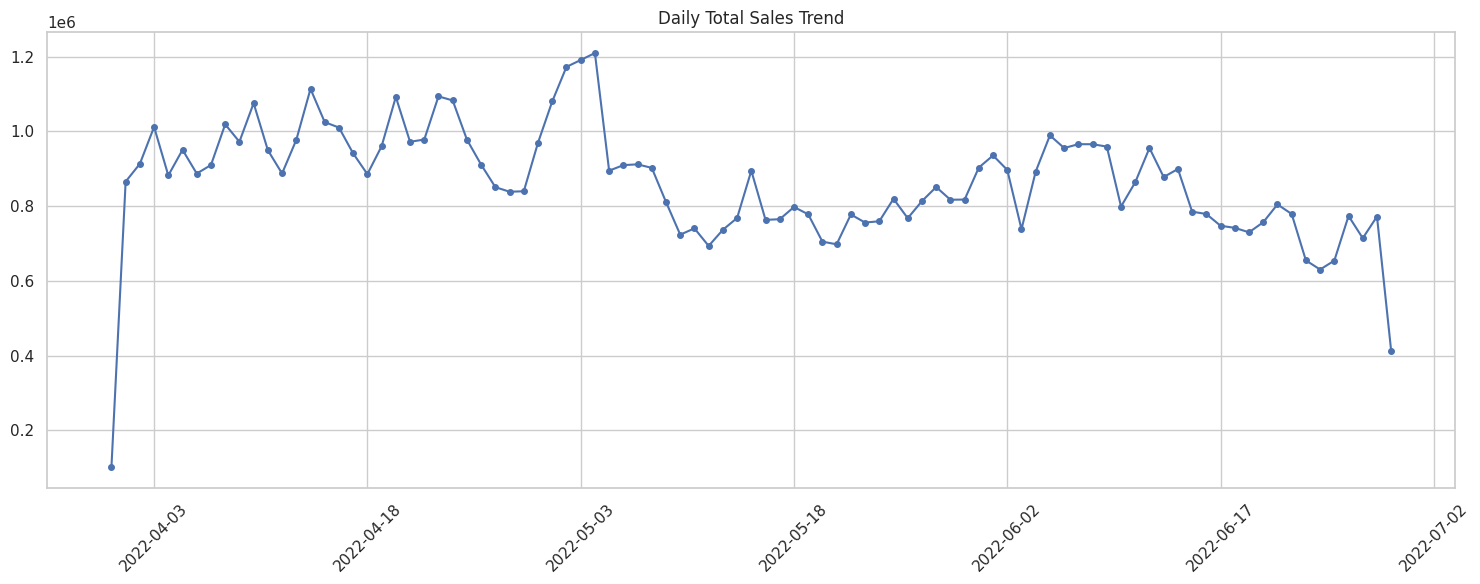

In [35]:
daily_sales = df.groupBy("Date").agg({"Amount": "sum"}) \
    .withColumnRenamed("sum(Amount)", "Total_Sales") \
    .orderBy("Date").toPandas()

plt.figure(figsize=(15, 6))
plt.plot(daily_sales['Date'], daily_sales['Total_Sales'], marker='o', markersize=4, color='b')

# Adjust the X-axis: Display the date every 15 days
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title("Daily Total Sales Trend")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

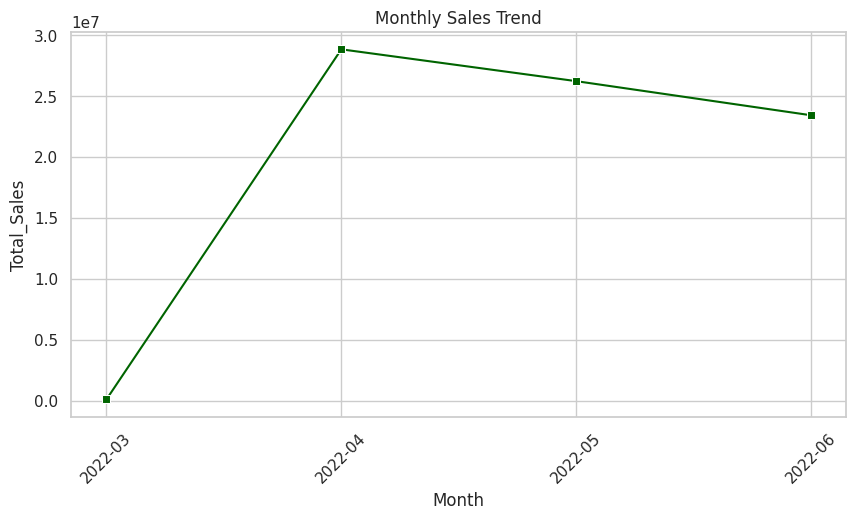

In [36]:
# 1. First, we convert the date string into a real DATE object (note the 'MM-dd-yy' format).
# 2. Then we convert this to the 'yyyy-MM' (Year-Month) format.
monthly_sales = df.withColumn("Actual_Date", to_date(col("Date"), "MM-dd-yy")) \
    .groupBy(date_format("Actual_Date", "yyyy-MM").alias("Month")) \
    .agg({"Amount": "sum"}) \
    .withColumnRenamed("sum(Amount)", "Total_Sales") \
    .filter(col("Month").isNotNull()) \
    .orderBy("Month").toPandas()

# Graph Drawing
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_sales, x='Month', y='Total_Sales', marker='s', color='darkgreen')
plt.title("Monthly Sales Trend")
plt.xticks(rotation=45)
plt.show()

### Visualize the top 10 categories with a bar chart.

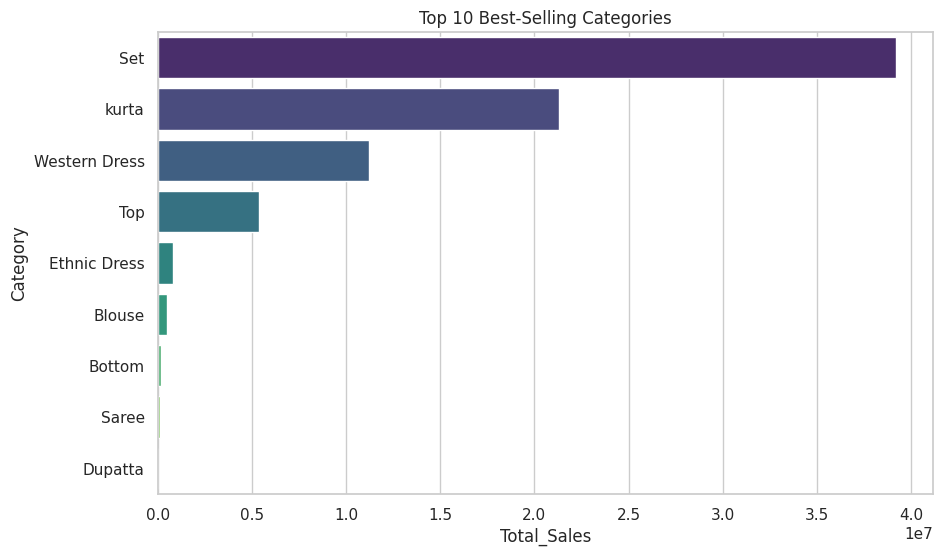

In [37]:
top_categories = df.groupBy("Category").agg({"Amount": "sum"}) \
    .withColumnRenamed("sum(Amount)", "Total_Sales") \
    .orderBy(col("Total_Sales").desc()).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_categories, x='Total_Sales', y='Category', palette='viridis')
plt.title("Top 10 Best-Selling Categories")
plt.show()

### Show average sales by cities.

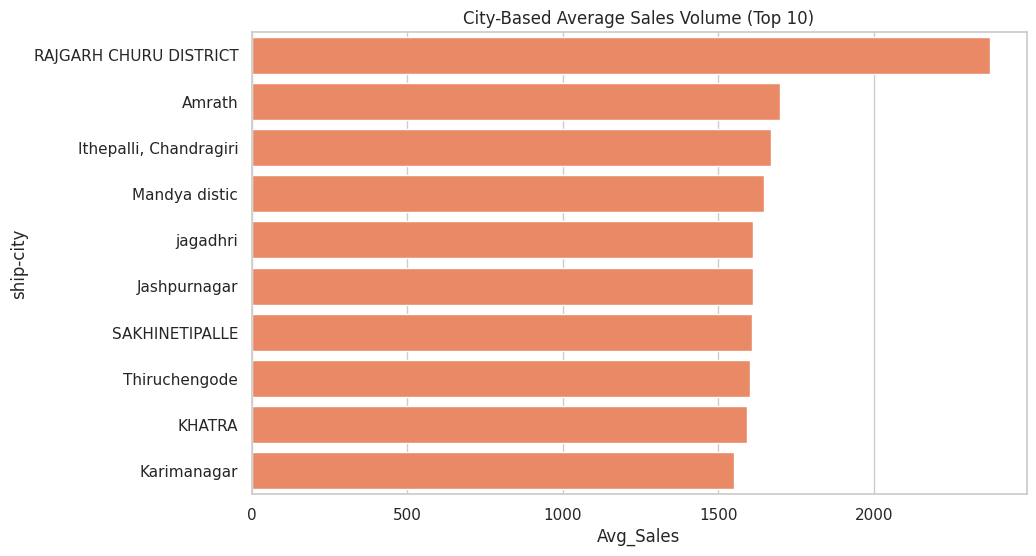

In [38]:
city_avg_sales = df.groupBy("ship-city").agg({"Amount": "avg"}) \
    .withColumnRenamed("avg(Amount)", "Avg_Sales") \
    .orderBy(col("Avg_Sales").desc()).limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=city_avg_sales, x='Avg_Sales', y='ship-city', color='coral')
plt.title("City-Based Average Sales Volume (Top 10)")
plt.show()

### Create a chart comparing B2B and B2C sales.

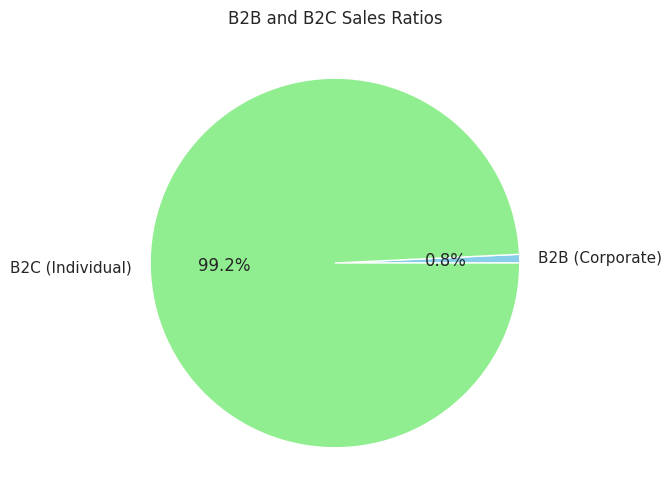

In [39]:
b2b_comparison = df.groupBy("B2B").agg({"Amount": "sum"}) \
    .withColumnRenamed("sum(Amount)", "Total_Sales").toPandas()

# Let's make the True/False values clearer
b2b_comparison['B2B'] = b2b_comparison['B2B'].map({True: 'B2B (Corporate)', False: 'B2C (Individual)'})

plt.figure(figsize=(8, 6))
plt.pie(b2b_comparison['Total_Sales'], labels=b2b_comparison['B2B'], autopct='%1.1f%%', colors=['skyblue', 'lightgreen'])
plt.title("B2B and B2C Sales Ratios")
plt.show()

## Section 8.5 - Advanced Visualizations

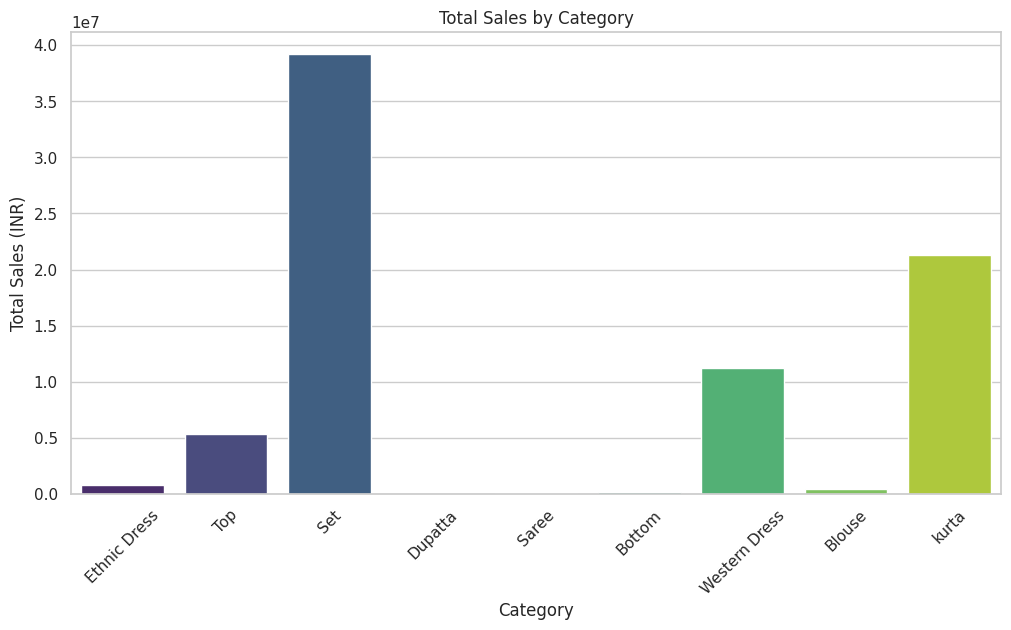

In [42]:
# 1. Total Sales by Category (Bar Chart)
cat_sales_pd = df.groupBy("Category").sum("Amount").toPandas()
plt.figure(figsize=(12, 6))
sns.barplot(data=cat_sales_pd, x='Category', y='sum(Amount)', palette='viridis')
plt.title('Total Sales by Category')
plt.xticks(rotation=45)
plt.ylabel('Total Sales (INR)')
plt.show()



In [43]:
df.agg((F.sum("Amount") / F.sum("Qty")).alias("Avg_Basket")).show()

+----------------+
|      Avg_Basket|
+----------------+
|674.719512886111|
+----------------+



# Conclusion

In this analysis, we processed Amazon sales data using PySpark to demonstrate Big Data capabilities. Key takeaways:
*   **Data Integrity**: We cleaned missing values and standardized formats.
*   **Sales Trends**: We analyzed sales across categories and time periods.
*   **Scalability**: We demonstrated how Spark can handle data processing (Filter, GroupBy, Join) efficiently compared to traditional pandas methods.
*   **Streaming**: We simulated a real-time ingestion pipeline.

The project highlights the effectiveness of PySpark for ETL and exploratory analysis on e-commerce datasets.